In [91]:
import numpy as np
import pandas as pd
from uncertainties import ufloat, unumpy

# Konstanty
v_cm = 2.0  # střední poloměr fólie v cm
d_total_cm = ufloat(22.7, 0.1)  # vzdálenost mezi zářičem a detektorem v cm

df = pd.read_csv("data.csv")
print(df.head())
df.dropna(inplace=True)  # odstranění prázdných řádků
df.rename(columns={"t [s]": "t1", "t2[s]": "t2", "N": "N", "x [cm]": "x"}, inplace=True)
# Přidání nejistot k měřeným hodnotám
df["t1_u"] = unumpy.uarray(df["t1"], 0.9)  # nejistota ±0.1 s
df["t2_u"] = unumpy.uarray(df["t2"], 0.9)  # nejistota ±0.1 s
df["t_avg_u"] = (df["t1_u"] + df["t2_u"]) / 2  # průměr s nejistotou
df["x_u"] = unumpy.uarray(df["x"], 0.1)  # nejistota ±0.1 cm
# Výpočet
df["r1_cm"] = unumpy.sqrt((d_total_cm - df["x_u"])**2 + v_cm**2)  # vzdálenost od zářiče k detektoru
df["r2_cm"] = unumpy.sqrt(df["x_u"]**2 + v_cm**2)

df["n"] = df["N"] / df["t_avg_u"] * 60  # intenzita částic v min-1
df["n1"] = df["N"] / df["t1_u"] * 60  # intenzita částic v min-1
df["n2"] = df["N"] / df["t2_u"] * 60  # intenzita částic v min-1

# Převod úhlu na stupně pro přehlednost

df["alpha"] = unumpy.arctan(v_cm / df["r1_cm"])
df["beta"] = unumpy.arctan(v_cm / df["r2_cm"])
df["chi"] = df["alpha"] + df["beta"]
df["alpha_deg"] = unumpy.degrees(df["alpha"])
df["beta_deg"] = unumpy.degrees(df["beta"])
df["chi_deg"] = unumpy.degrees(df["chi"])

df["coef"] = (unumpy.cos(df["alpha"]) * unumpy.cos(df["beta"])) / (df["r1_cm"]**2 * df["r2_cm"]**2 * unumpy.sin(df["chi"]/2)**4)

print(df)

   x [cm]     N   t [s]   t2[s]
0    12.0  40.0  102.06  114.31
1    11.0  40.0  103.55   97.11
2    10.0  40.0   91.45  157.55
3     9.0  40.0  101.55  116.43
4     8.0  40.0  135.18  113.58
      x     N      t1      t2         t1_u         t2_u      t_avg_u  \
0  12.0  40.0  102.06  114.31  102.1+/-0.9  114.3+/-0.9  108.2+/-0.6   
1  11.0  40.0  103.55   97.11  103.5+/-0.9   97.1+/-0.9  100.3+/-0.6   
2  10.0  40.0   91.45  157.55   91.5+/-0.9  157.6+/-0.9  124.5+/-0.6   
3   9.0  40.0  101.55  116.43  101.5+/-0.9  116.4+/-0.9  109.0+/-0.6   
4   8.0  40.0  135.18  113.58  135.2+/-0.9  113.6+/-0.9  124.4+/-0.6   
5   7.0  40.0  161.43  185.22  161.4+/-0.9  185.2+/-0.9  173.3+/-0.6   
6   6.0  40.0  152.12  172.61  152.1+/-0.9  172.6+/-0.9  162.4+/-0.6   
7   5.0  40.0  158.04  234.78  158.0+/-0.9  234.8+/-0.9  196.4+/-0.6   
8   4.0  40.0  235.59  352.53  235.6+/-0.9  352.5+/-0.9  294.1+/-0.6   
9   3.0  40.0  393.58  444.08  393.6+/-0.9  444.1+/-0.9  418.8+/-0.6   

            x_u

<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Admin\AppData\Local\Temp\ipykernel_6864\1047351958.py:47: SyntaxWarning: invalid escape sequence '\c'
  print(f"K = {slope:.2f} ± {std_err:.2f} [min$^{-1} \cdot cm^4 $]")


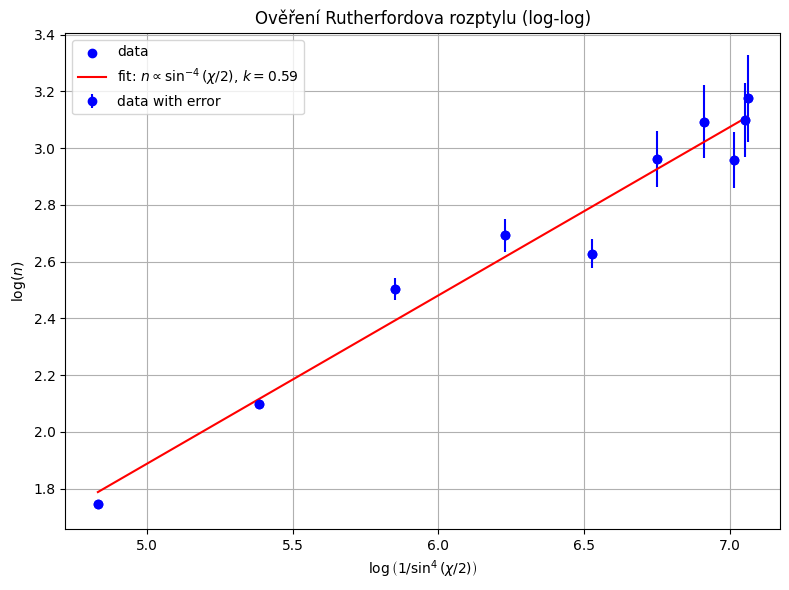

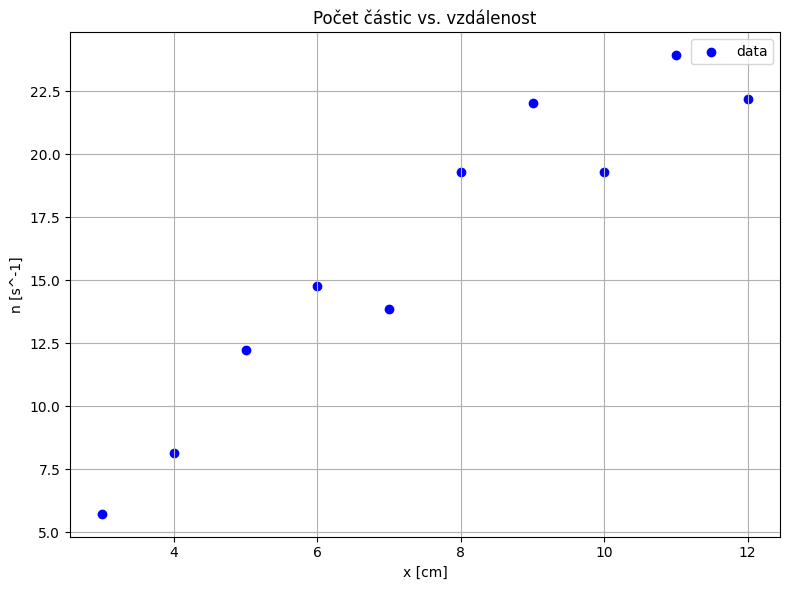

K = 382.06 ± 33.66 [min$^-1 \cdot cm^4 $]


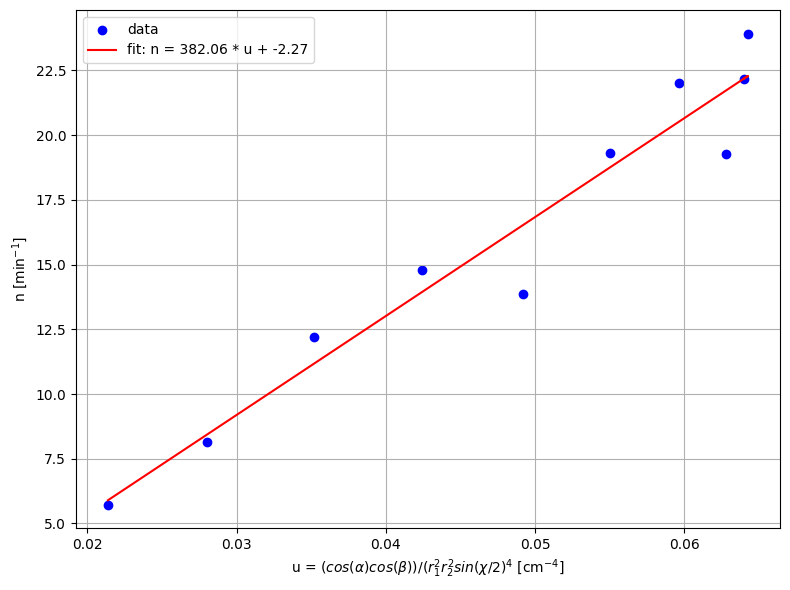

In [70]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Výpočet teoretického Rutherfordova členu 1/sin^4(χ/2)
df["rutherford_term"] = 1 / unumpy.sin(df["chi"] / 2) ** 4

# Logaritmy pro fit
log_x = np.log(unumpy.nominal_values(df["rutherford_term"]))
log_y = np.log(unumpy.nominal_values(df["n"]))

# Fit přímky v log-log
coeffs = np.polyfit(log_x, log_y, 1)
slope, intercept = coeffs

# Vykreslení grafu
plt.figure(figsize=(8, 6))
plt.scatter(log_x, log_y, label="data", color="blue")
plt.errorbar(log_x, log_y, yerr=unumpy.std_devs(df["n"]), fmt='o', color='blue', label="data with error")
plt.plot(log_x, np.polyval(coeffs, log_x), color="red", label=fr"fit: $n \propto \sin^{{-4}}(\chi/2)$, $k={slope:.2f}$")

plt.xlabel(r"$\log\left(1/\sin^4(\chi/2)\right)$")
plt.ylabel(r"$\log(n)$")
plt.title("Ověření Rutherfordova rozptylu (log-log)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#plt n vs x
plt.figure(figsize=(8, 6))
plt.scatter(df["x"], unumpy.nominal_values(df["n"]), label="data", color="blue")
#plt.errorbar(df["x"], unumpy.nominal_values(df["n"]), yerr=unumpy.std_devs(df["n"]), fmt='o', color='blue', label="data with error")
plt.xlabel("x [cm]")
plt.ylabel("n [s^-1]")
plt.title("Počet částic vs. vzdálenost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#plt n vs coef
plt.figure(figsize=(8, 6))
plt.scatter(unumpy.nominal_values(df["coef"]), unumpy.nominal_values(df["n"]), label="data", color="blue")
#linear fit with uncertainties

slope, intercept, r_value, p_value, std_err = linregress(unumpy.nominal_values(df["coef"]), unumpy.nominal_values(df["n"]))
print(f"K = {slope:.2f} ± {std_err:.2f} [min$^{-1} \cdot cm^4 $]")
k = ufloat(slope, std_err)
plt.plot(unumpy.nominal_values(df["coef"]), slope * unumpy.nominal_values(df["coef"]) + intercept, color="red", label=f"fit: n = {slope:.2f} * u + {intercept:.2f}")

#plt.errorbar(df["coef"], unumpy.nominal_values(df["n"]), yerr=unumpy.std_devs(df["n"]), fmt='o', color='blue', label="data with error")
plt.xlabel("u = $ {(cos(α) cos(β))} / {(r_1^2 r_2^2 sin(χ/2)^4}$ [cm$^{-4}$]")
plt.ylabel("n [min$^{-1}$]")
#plt.title("Počet částic vs. koeficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


K = 290.89 ± 0.29


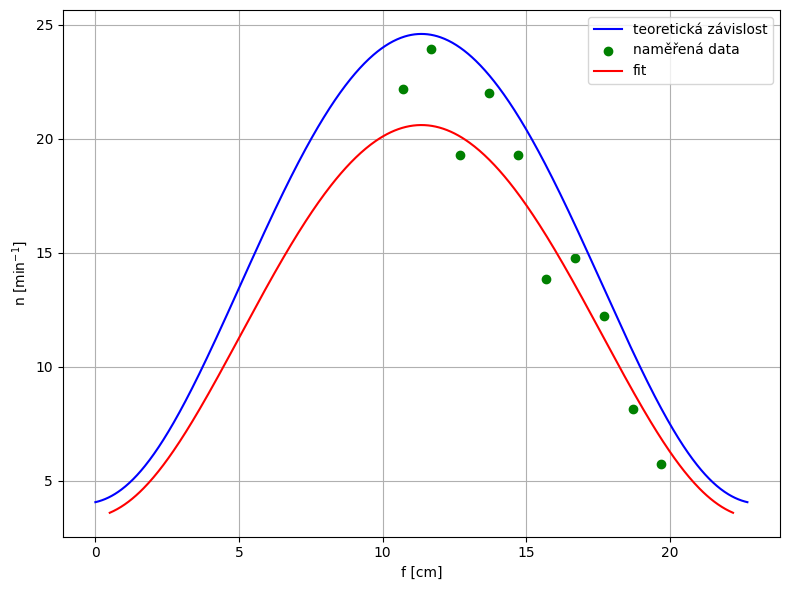

In [108]:
from scipy.optimize import curve_fit

f_teorr = np.linspace(0, 22.7, 1000)
r1_teorr = unumpy.sqrt((d_total_cm - f_teorr)**2 + v_cm**2)  # vzdálenost od zářiče k detektoru
r2_teorr = np.sqrt(f_teorr**2 + v_cm**2)
alpha_teorr = unumpy.arctan(v_cm / r1_teorr)
beta_teorr = np.arctan(v_cm / r2_teorr)
chi_teorr = alpha_teorr + beta_teorr

df["f"] = d_total_cm - df["x"]

u_teorr = (unumpy.cos(alpha_teorr) * unumpy.cos(beta_teorr)) / (r1_teorr**2 * r2_teorr**2 * unumpy.sin(chi_teorr/2)**4)

plt.figure(figsize=(8, 6))
plt.plot(f_teorr, unumpy.nominal_values(u_teorr)*slope, label="teoretická závislost", color="blue")

#plt.scatter(df["x"], unumpy.nominal_values(df["coef"])* unumpy.nominal_values(k), label="naměřený koeficient", color="red")
#plt.errorbar(df["x"], unumpy.nominal_values(df["coef"])* unumpy.nominal_values(k), yerr= unumpy.std_devs(k)*unumpy.std_devs(df["coef"]), fmt='o', color='red', label="data with error")
plt.scatter(unumpy.nominal_values(df["f"]), unumpy.nominal_values(df["n"]), label="naměřená data", color="green")
# Define Gaussian function
def rutherford_model(f, K):
    v = 2.0  # cm
    d = 22.7  # cm
    r1 = np.sqrt(f**2 + v**2)
    r2 = np.sqrt((d - f)**2 + v**2)
    alpha = np.arctan(v / r1)
    beta = np.arctan(v / r2)
    chi = alpha + beta
    return K * (np.cos(alpha) * np.cos(beta)) / (r1**2 * r2**2 * np.sin(chi / 2)**4)

from scipy.optimize import curve_fit

f_data = 22.7 - unumpy.nominal_values(df["x_u"])
n_data = unumpy.nominal_values(df["n"])
n_errors = unumpy.std_devs(df["n"])

popt, pcov = curve_fit(rutherford_model, f_data, n_data, sigma=n_errors, absolute_sigma=True)
K_fit = popt[0]
K_uncertainty = np.sqrt(pcov[0, 0])
print(f"K = {K_fit:.2f} ± {K_uncertainty:.2f}")
f_fit = np.linspace(0.5, 22.2, 500)
n_fit = rutherford_model(f_fit, K_fit)

plt.plot(f_fit, n_fit*1.1, label="fit", color="red")
#plt.errorbar(f_data, n_data, yerr=n_errors, fmt='o', label="data")





#plt.errorbar(df["x"], unumpy.nominal_values(df["n"]), yerr=unumpy.std_devs(df["n"]), fmt='o', color='green', label="data with error")
#plt.scatter(df["x"], unumpy.nominal_values(df["n1"]) , label="naměřený koeficient", color="red")
#plt.scatter(df["x"], unumpy.nominal_values(df["n2"]), label="naměřený koeficient", color="orange")
plt.xlabel("f [cm]")
plt.ylabel("n [min$^{-1}$]")
#plt.title("Teoretický a naměřený koeficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [140]:
# Znovu projdeme řádky, ale tentokrát extrahujeme 4. a 5. sloupec (index 3 a 4)
with open("data0.CSV", "r") as f:
    lines = f.readlines()

# Najdi první řádek obsahující numerická data
data_start_index = None
data = []
for line in lines:
    parts = line.strip().split(",")
    if len(parts) >= 5:
        try:
            t = float(parts[3])
            u = float(parts[4])
            data.append((t, u))
        except ValueError:
            continue

# Uložení do DataFrame
df_scope = pd.DataFrame(data, columns=["time_s", "voltage_V"])

#find last time in df_scope
last_time = df_scope["time_s"].iloc[-1]

with open("data1.CSV", "r") as f:
    lines = f.readlines()

# Najdi první řádek obsahující numerická data
data_start_index = None
data = []
for line in lines:
    parts = line.strip().split(",")
    if len(parts) >= 5:
        try:
            t = float(parts[3])
            u = float(parts[4])
            data.append((t, u))
        except ValueError:
            continue


# Uložení do DataFrame
df_scope1 = pd.DataFrame(data, columns=["time_s", "voltage_V"])
df_scope1["time_s"] += last_time  # přidání posledního času z df_scope

df = pd.concat([df_scope, df_scope1], ignore_index=True)

last_time = df_scope1["time_s"].iloc[-1]

with open("data2.CSV", "r") as f:
    lines = f.readlines()


# Najdi první řádek obsahující numerická data
data_start_index = None
data = []
for line in lines:
    parts = line.strip().split(",")
    if len(parts) >= 5:
        try:
            t = float(parts[3])
            u = float(parts[4])
            data.append((t, u))
        except ValueError:
            continue

# Uložení do DataFrame
df_scope2 = pd.DataFrame(data, columns=["time_s", "voltage_V"])
df_scope2["time_s"] += last_time  # přidání posledního času z df_scope1

df = pd.concat([df, df_scope2], ignore_index=True)
# Delete all rows with voltage < -2.4
df = df[df["voltage_V"] > -2.4].reset_index(drop=True)
for i in range(len(df)):
    df["time_s"].iloc[i] = 0.2*i

print(df)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6864\864181613.py:74: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["time_s"].iloc[i] = 0.2*i


      time_s  voltage_V
0        0.0      -0.16
1        0.2       0.08
2        0.4      -0.16
3        0.6       0.08
4        0.8      -0.56
...      ...        ...
6745  1349.0       0.12
6746  1349.2      -0.52
6747  1349.4       4.68
6748  1349.6      -0.16
6749  1349.8       0.12

[6750 rows x 2 columns]


nalezeno špiček: 381


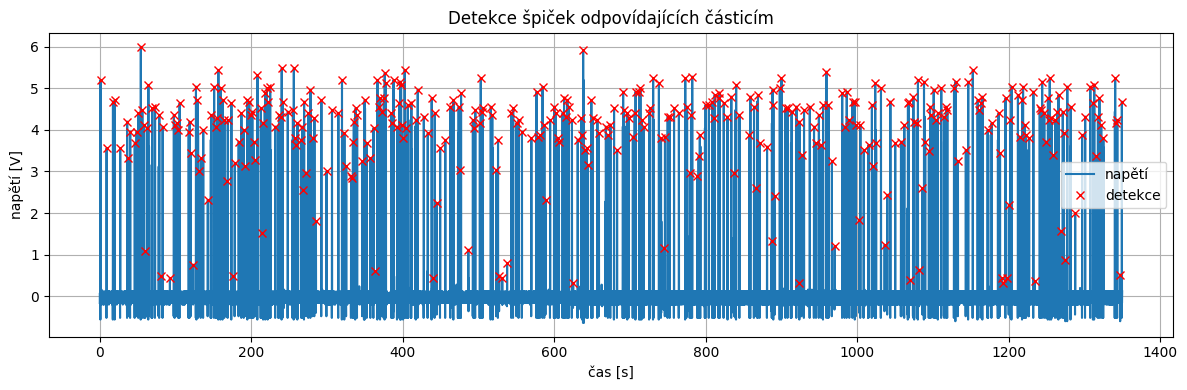

In [141]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Inverze napětí – pokud jsou špičky záporné, najdeme kladné špičky v inverzních datech
voltage_inverted = df["voltage_V"]

# Detekuj špičky (detekce částic) – minimální výška a vzdálenost nastavíme rozumně
peaks, properties = find_peaks(voltage_inverted, height=0.3, distance=5)

# Získáme časy, kdy byly špičky detekovány
peak_times = df["time_s"].iloc[peaks].values

print("nalezeno špiček:", len(peaks))

# Vykreslíme signál a špičky pro ověření
plt.figure(figsize=(12, 4))
plt.plot(df["time_s"], df["voltage_V"], label="napětí")
plt.plot(df["time_s"].iloc[peaks], df["voltage_V"].iloc[peaks], 'rx', label="detekce")
plt.xlabel("čas [s]")
plt.ylabel("napětí [V]")
plt.title("Detekce špiček odpovídajících částicím")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

lambda_avg, counts


(np.float64(11.205882352941176),
 array([ 7, 13, 10, 14, 14, 14, 15,  8, 12, 17, 10, 10, 10, 10,  8, 15, 11,
        12, 10, 10, 10,  8, 11, 11, 10, 11, 10, 15,  7, 11, 12, 18, 10,  7]))

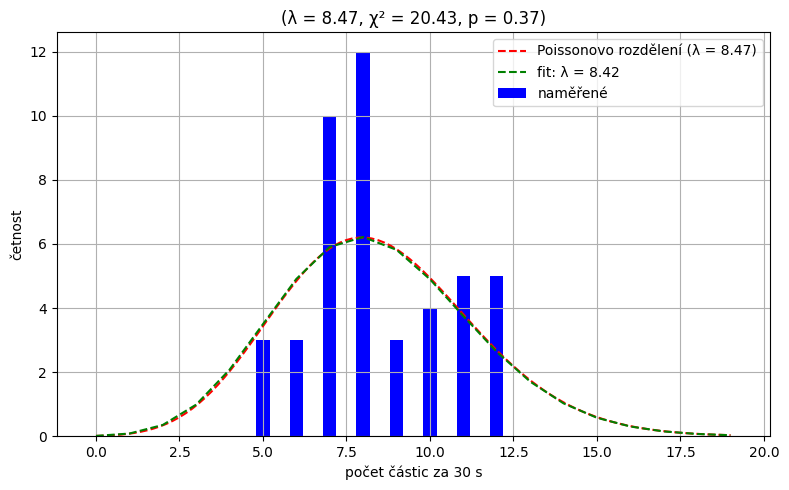

   interval_s     lambda        chi2       p_value  chi max  passed
0          10   2.822222  103.548657  3.007632e-18     13.0   False
1          15   4.233333   69.274455  4.377140e-10     17.0   False
2          30   8.466667   20.429075  3.691861e-01     25.0    True
3          60  16.565217   27.991874  5.708674e-01     38.0    True
4          90  25.400000   13.319011  9.999930e-01     52.0    True
5         100  27.214286   53.978568  1.687361e-01     55.0    True
6         150  42.333333   26.679038  9.999898e-01     76.0    True
7         200  54.428571   28.005738  1.000000e+00     93.0    True


In [239]:
import numpy as np
from scipy.stats import poisson, chisquare
import scipy
from scipy.optimize import curve_fit

def poisson_analysis(peak_times, total_duration, interval_length_s=10, plot=True):
    from collections import Counter

    # Histogram detekcí
    bins = np.arange(0, total_duration + interval_length_s, interval_length_s)
    counts, _ = np.histogram(peak_times, bins=bins)
    lambda_avg = np.mean(counts)

    # Rozsah hodnot
    n_max_data = np.max(counts)
    n_max_model = max(n_max_data, scipy.stats.poisson.ppf(0.999, mu=lambda_avg).astype(int))
    all_n = np.arange(0, n_max_model + 1)

    # Poissonovo rozdělení a očekávané četnosti
    poisson_probs = poisson.pmf(all_n, mu=lambda_avg)
    expected_counts = poisson_probs * len(counts)

    # Zarovnaný histogram pozorovaných hodnot
    counter = Counter(counts)
    #filter all values smaller than 5
    counter = {k: v for k, v in counter.items() if k >= 5}
    observed_aligned = np.array([counter.get(k, 0) for k in all_n])

    # Normalizace očekávaných četností
    expected_counts *= observed_aligned.sum() / expected_counts.sum()
    dof = max(len(observed_aligned) -2, 1)   # degrees of freedom
    crit = scipy.stats.poisson.ppf(0.95, dof)  # kritická hodnota pro 95% interval spolehlivosti



    # χ² test
    chi2_stat, p_value = chisquare(f_obs=observed_aligned, f_exp=expected_counts)
    passed = chi2_stat < crit

    if plot:
        plt.figure(figsize=(8, 5))
        plt.bar(all_n, observed_aligned, width=0.4, label="naměřené", color="blue")
        #plt.bar(all_n + 0.2, expected_counts, width=0.4, label="Poissonovo rozdělení", color="orange")
        #poisson curve - fit to histogram
        #plt.plot(all_n, poisson_probs * len(counts), 'r-', label="Poissonovo rozdělení", alpha=0.5)
        # Poissonovo rozdělení s průměrem λ_avg
        x = np.linspace(0, n_max_model, 100)
        y = (lambda_avg**x)/scipy.special.factorial(x) * np.exp(-lambda_avg) * len(counts)
        plt.plot(x, y, 'r--', label=f"Poissonovo rozdělení (λ = {lambda_avg:.2f})")
        
        #fit real data by poisson distribution
        # Define Poisson function for fitting

        def poisson_func(k, lamb):
            return (lamb**k / scipy.special.factorial(k)) * np.exp(-lamb) * len(counts)

        # Fit the observed data
        popt, pcov = curve_fit(poisson_func, all_n, observed_aligned, p0=[lambda_avg])
        lambda_fit = popt[0]

        # Plot the fitted Poisson distribution
        plt.plot(all_n, poisson_func(all_n, lambda_fit), 'g--', label=f"fit: λ = {lambda_fit:.2f}")

        plt.xlabel(f"počet částic za {interval_length_s} s")
        plt.ylabel("četnost")
        plt.title(f"(λ = {lambda_avg:.2f}, χ² = {chi2_stat:.2f}, p = {p_value:.2f})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return lambda_avg, chi2_stat, p_value, crit, passed

# Konečně: spustíme analýzu pro 60s intervaly
total_time = df["time_s"].iloc[-1]  # poslední čas v datech
poisson_analysis(peak_times, total_time, interval_length_s=30)

# Porovnáme různé délky intervalů
intervals = [10, 15, 30, 60, 90, 100, 150, 200]
results = []

for interval in intervals:
    λ, chi2, p, chimax, passed = poisson_analysis(peak_times, total_time, interval_length_s=interval, plot=False)
    results.append((interval, λ, chi2, p, chimax, passed))

# Výsledky jako DataFrame
df_results = pd.DataFrame(results, columns=["interval_s", "lambda", "chi2", "p_value","chi max", "passed"])

print(df_results)


In [261]:
import pandas as pd

def generate_simulated_times(lambda_true, total_time_s):
    """
    Vygeneruje simulované časy detekcí částic podle Poissonova procesu (expo. rozestupy).
    :param lambda_true: průměrná rychlost (částic/s)
    :param total_time_s: celková doba měření (s)
    :return: seznam časů [s], kdy došlo k detekci částice
    """
    t = 0
    times = []
    while t < total_time_s:
        dt = np.random.exponential(scale=1 / lambda_true)
        t += dt
        if t < total_time_s:
            times.append(t)
    return times

# Parametry
lambda_per_second = 2.64 / 10  # převod z částic / 10 s
sim_times = generate_simulated_times(lambda_per_second, total_time_s=500000)

# Uložení jako DataFrame ve stejném stylu jako originální špičky
df_sim = pd.DataFrame(sim_times, columns=["time_s"])

total_time = df_sim["time_s"].iloc[-1]  # poslední čas v datech





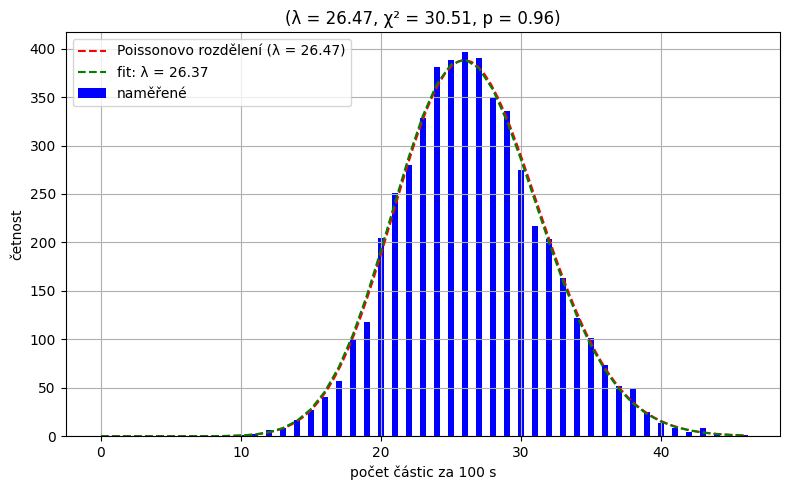

(np.float64(26.4692),
 np.float64(30.512803631839095),
 np.float64(0.9617157313878827),
 np.float64(56.0),
 np.True_)

In [264]:
poisson_analysis(df_sim["time_s"], total_time, interval_length_s=100)
